In [1]:
import numpy as np
import mujoco
import mediapy as media
import copy
import scipy
from robot_descriptions.skydio_x2_mj_description import MJCF_PATH

In [2]:
model = mujoco.MjModel.from_xml_path(MJCF_PATH)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model, height=480, width=640)

for act_id in range(4):
    model.actuator(act_id).ctrlrange = np.array([-1e4, 1e4])

model.opt.timestep = 1e-3
model.opt.viscosity = 0
model.opt.density = 0

In [3]:
# load trajectory
traj = np.load("trajectory.npz")

traj["q"].shape, traj["v"].shape, traj["u"].shape

((7, 41), (6, 41), (4, 40))

In [4]:
from scipy.linalg import solve_discrete_are as dare


def dlqr_ltv(A, B, Q, R, P_last):
    """Discrete time LTV LQR controller"""
    N = np.shape(A)[0]
    n = np.shape(A)[1]
    m = np.shape(B)[2]

    # Matrix to store cost-to-go
    P = np.zeros((N, n, n))
    P[-1] = Q
    # Matrix to store gains
    K = np.zeros((N, m, n))

    for k in range(N - 2, -1, -1):
        # Compute the LQR gain
        invM_k = np.linalg.inv(R + B[k].T @ P[k + 1] @ B[k])
        K[k] = invM_k @ B[k].T @ P[k + 1] @ A[k]
        Ac_k = A[k] - B[k] @ K[k]  # Update with difference Riccati equation
        # Compute cost-to-go matrix
        P[k] = Q + K[k].T @ R @ K[k] + Ac_k.T @ P[k + 1] @ Ac_k

    return K, P


def dlqr(A, B, Q, R):
    """Discrete time LTI LQR"""
    # Solve discrete Ricatti equation (DARE)
    P = dare(A, B, Q, R)
    # Compute the LQR gain
    K = np.linalg.inv(B.T @ P @ B + R) @ (B.T @ P @ A)
    return K, P

In [5]:
# find linearization over trajectory
def linearize(q, u) -> tuple[np.ndarray, np.ndarray]:
    newdata = mujoco.MjData(model)
    newdata = copy.copy(data)

    mujoco.mj_resetData(model, newdata)
    newdata.ctrl = u
    newdata.qpos = q

    # 4. Allocate the A and B matrices, compute them.
    A = np.zeros((2 * model.nv, 2 * model.nv))
    B = np.zeros((2 * model.nv, model.nu))
    epsilon = 1e-6  # model.opt.timestep
    flg_centered = False
    mujoco.mjd_transitionFD(model, newdata, epsilon, flg_centered, A, B, None, None)

    return A, B

In [6]:
# linearize around trajectory
A_traj = []
B_traj = []

n_pts = traj["u"].shape[1]
traj_t = traj["t"]
traj_dt = traj_t / n_pts

for i in range(n_pts):
    A, B = linearize(traj["q"][:, i], traj["u"][:, i])
    A_traj.append(A)
    B_traj.append(B)

# find gains to track trajectory for LTV LQR
Q = np.eye(2 * model.nv)
# Q[6:, 6:] /= 5.0
# Q[:3, :3] = np.eye(3) * 1e2
# Q[6:9, 6:9] = np.eye(3) * 1e2
R = np.eye(model.nu)


# find gains for stabilization at the end
K_stab, P_stab = dlqr(A_traj[-1], B_traj[-1], Q, R)
K, _ = dlqr_ltv(A_traj, B_traj, Q, R, P_stab)

In [7]:
FRAMERATE = 20  # Hz

# store different in tangent space between configurations
dq = np.zeros(model.nv)

# Reset data, set initial pose.
mujoco.mj_resetData(model, data)
data.qpos = traj["q"][:, 0]

last_time = 0
phase = 0

hist_qpos = []
hist_target_qpos = []

frames = []
while data.time < traj_t:
    hist_qpos.append(data.qpos.copy())

    traj_idx = (
        int(data.time / traj_dt) if data.time < traj_t else int(traj_t / traj_dt) - 1
    )
    q_target = traj["q"][:, traj_idx]
    v_target = traj["v"][:, traj_idx]
    u_target = traj["u"][:, traj_idx]

    hist_target_qpos.append(q_target.copy())

    # q_target = traj["q"][:, 0]
    # q_target[3:7] = [1, 0, 0, 0]
    # u_target = 1.325 * 9.81 / 4 * np.ones(4)
    # v_target *= 0

    # Get state difference dx.
    mujoco.mj_differentiatePos(model, dq, 1, q_target, data.qpos.copy())

    # dq[:3] = q_target[:3] - data.qpos[:3]
    dv = data.qvel.copy() - v_target
    # dv[:3] = -dv[:3]
    dx = np.hstack((dq, dv)).T
    dx[:3] = -dx[:3]
    dx[6:9] = -dx[6:9]

    # LQR control law.
    data.ctrl = u_target - K[traj_idx] @ dx
    # data.ctrl = u_target - K_stab @ dx

    # Step the simulation.
    mujoco.mj_step(model, data)

    # Render and save frames.
    if len(frames) < data.time * FRAMERATE:
        renderer.update_scene(data)
        pixels = renderer.render()
        frames.append(pixels)

media.show_video(frames, fps=FRAMERATE)

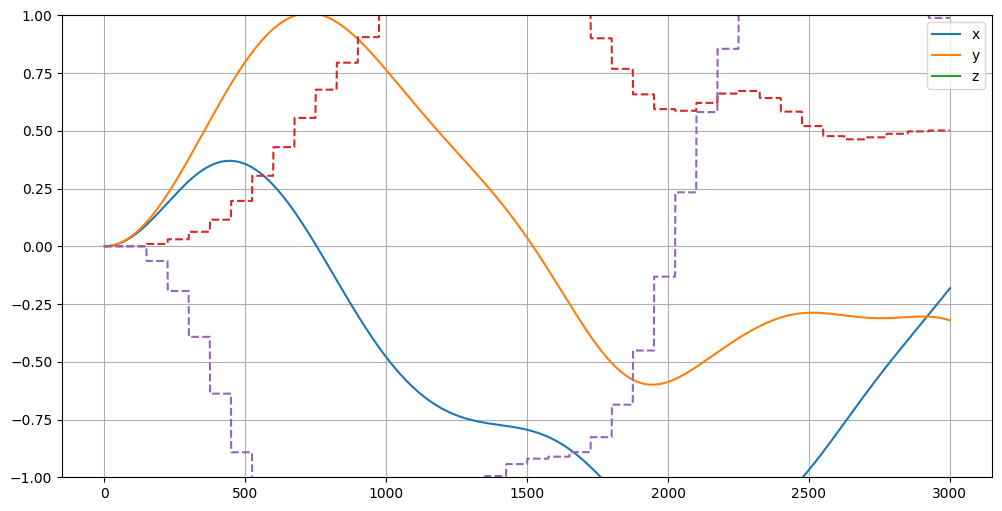

In [8]:
import matplotlib.pyplot as plt

hist_qpos = np.array(hist_qpos)
hist_target_qpos = np.array(hist_target_qpos)

plt.figure(figsize=(12, 6))
plt.plot(hist_qpos[:, :3], label=["x", "y", "z"])
plt.plot(hist_target_qpos[:, :3], linestyle="--")
plt.ylim([-1, 1])

plt.legend()
plt.grid()

plt.show()

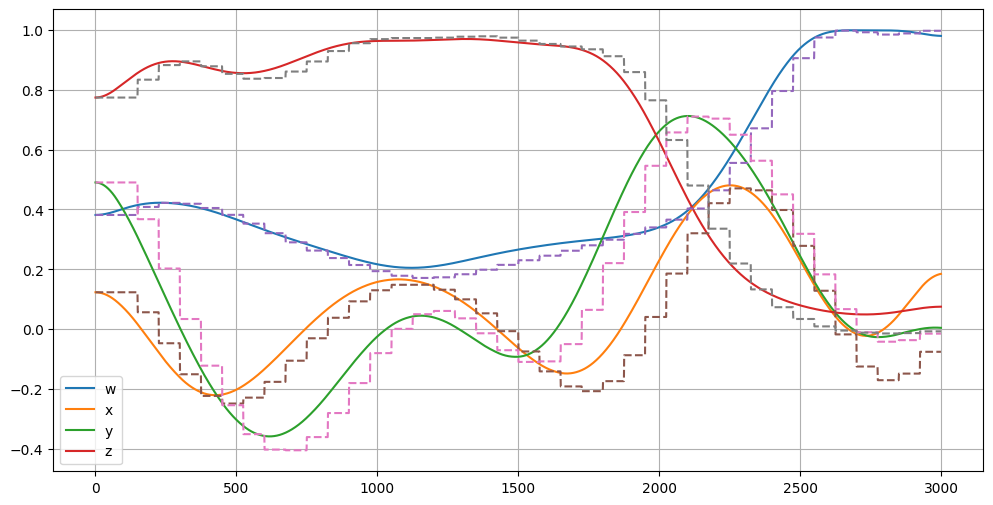

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(hist_qpos[:, 3:], label=["w", "x", "y", "z"])
plt.plot(hist_target_qpos[:, 3:], linestyle="--")

plt.legend()
plt.grid()

plt.show()

In [10]:
mujoco.mj_differentiatePos()

TypeError: mj_differentiatePos(): incompatible function arguments. The following argument types are supported:
    1. (m: mujoco._structs.MjModel, qvel: numpy.ndarray[numpy.float64[m, 1], flags.writeable], dt: float, qpos1: numpy.ndarray[numpy.float64[m, 1]], qpos2: numpy.ndarray[numpy.float64[m, 1]]) -> None

Invoked with: 

In [ ]:
def compute_gains(configuration):
    # 1. Set configuration and find control that stabilizes it (ctrl0)
    newdata = mujoco.MjData(model)
    newdata = copy.copy(data)

    mujoco.mj_resetData(model, newdata)
    newdata.qpos = configuration
    # compute the control
    mujoco.mj_forward(model, newdata)
    newdata.qacc = 0
    mujoco.mj_inverse(model, newdata)

    # define control and configuration to linearize around
    ctrl0 = newdata.qfrc_inverse.copy() @ np.linalg.pinv(newdata.actuator_moment)
    qpos0 = newdata.qpos.copy()
    print(ctrl0, qpos0)

    # 2. Set weights
    R = np.eye(4)
    Q = np.block(
        [
            [np.eye(6), np.zeros((6, 6))],
            [np.zeros((6, 6)), np.eye(6)],
        ]
    )
    Q = np.eye(12)

    # 3. Compute LQR gains given weights
    mujoco.mj_resetData(model, newdata)
    newdata.ctrl = ctrl0
    newdata.qpos = qpos0

    # 4. Allocate the A and B matrices, compute them.
    A = np.zeros((2 * model.nv, 2 * model.nv))
    B = np.zeros((2 * model.nv, model.nu))
    epsilon = 1e-6
    flg_centered = False
    mujoco.mjd_transitionFD(model, newdata, epsilon, flg_centered, A, B, None, None)

    try:
        # Solve discrete Riccati equation.
        P = scipy.linalg.solve_discrete_are(A, B, Q, R)

        # Compute the feedback gain matrix K.
        K = np.linalg.inv(R + B.T @ P @ B) @ B.T @ P @ A
    except Exception as e:
        print("Error", e)

    # return A, B
    return ctrl0, K

In [ ]:
def Y_body(v_lin, v_ang, a_lin, a_ang):
    # this is identical to the pinnochio: pin.bodyRegressor(*[v_lin, v_ang], *[a_lin, a_ang])
    v1, v2, v3 = v_lin
    v4, v5, v6 = v_ang

    a1, a2, a3 = a_lin
    a4, a5, a6 = a_ang

    # fmt: off
    Y = np.array([
        [a1 - v2*v6 + v3*v5, -v5**2 - v6**2, -a6 + v4*v5, a5 + v4*v6, 0, 0, 0, 0, 0, 0],
        [a2 + v1*v6 - v3*v4, a6 + v4*v5, -v4**2 - v6**2, -a4 + v5*v6, 0, 0, 0, 0, 0, 0],
        [a3 - v1*v5 + v2*v4, -a5 + v4*v6, a4 + v5*v6, -v4**2 - v5**2, 0, 0, 0, 0, 0, 0],
        [0, 0, a3 - v1*v5 + v2*v4, -a2 - v1*v6 + v3*v4, a4, a5 - v4*v6, -v5*v6, a6 + v4*v5, v5**2 - v6**2, v5*v6],
        [0, -a3 + v1*v5 - v2*v4, 0, a1 - v2*v6 + v3*v5, v4*v6, a4 + v5*v6, a5, -v4**2 + v6**2, a6 - v4*v5, -v4*v6],
        [0, a2 + v1*v6 - v3*v4, -a1 + v2*v6 - v3*v5, 0, -v4*v5, v4**2 - v5**2, v4*v5, a4 - v5*v6, a5 + v4*v6, a6]
    ])
    # fmt: on

    return Y


def mj_bodyRegressor(mj_model, mj_data, body_id):
    velocity = np.zeros(6)
    accel = np.zeros(6)
    _cross = np.zeros(3)

    mujoco.mj_objectVelocity(mj_model, mj_data, 2, body_id, velocity, 1)
    mujoco.mj_rnePostConstraint(mj_model, mj_data)
    mujoco.mj_objectAcceleration(mj_model, mj_data, 2, body_id, accel, 1)
    # rotation = mj_data.xmat[body_id].reshape(3, 3).copy()

    v, w = velocity[3:], velocity[:3]
    dv, dw = accel[3:], accel[:3]  # dv - classical acceleration, already containt g
    mujoco.mju_cross(_cross, w, v)

    # in floating body, should be canceled?
    # dv -= _cross
    # print(v, w)
    # print(dv, dw)

    Y = Y_body(v, w, dv, dw)
    return Y

In [ ]:
zero_config = np.array([0, 0, 0, 1.0, 0, 0, 0])
A1, B1 = compute_gains(zero_config)

[3.2495625 3.2495625 3.2495625 3.2495625] [0. 0. 0. 1. 0. 0. 0.]


In [ ]:
zero_config = np.array([0, 0, 0.3, 1.0, 0, 0, 0])
A2, B2 = compute_gains(zero_config)

[3.2495625 3.2495625 3.2495625 3.2495625] [0.  0.  0.3 1.  0.  0.  0. ]


In [ ]:
np.allclose(A1, A2, atol=1e-3), np.allclose(B1, B2, atol=1e-3)

(True, False)

In [ ]:
# Parameters.
DURATION = 20  # seconds
FRAMERATE = 20  # Hz
BALANCE_STD = 0.3  # actuator units

dq = np.zeros(model.nv)

qpos0 = np.array([0, 0, 0, 1.0, 0, 0, 0])
zero_config = qpos0.copy()
ctrl0, K = compute_gains(zero_config)


# Reset data, set initial pose.
mujoco.mj_resetData(model, data)
data.qpos = qpos0

last_time = 0
phase = 0


frames = []
step = 0
while data.time < DURATION:
    # Get state difference dx.
    mujoco.mj_differentiatePos(model, dq, 1, zero_config, data.qpos)
    dx = np.hstack((dq, data.qvel)).T

    # LQR control law.
    data.ctrl = ctrl0 - K @ dx
    # data.xfrc_applied[1, :3] = np.random.randn(3) * BALANCE_STD

    # Step the simulation.
    mujoco.mj_step(model, data)

    if data.time > phase * 2.0:
        phase += 1
        zero_config[phase % 3] = 0.3
        zero_config[(phase + 1) % 3] = 0.3
        zero_config[(phase + 2) % 3] = 0
        ctrl0, K = compute_gains(zero_config)

    # Render and save frames.
    if len(frames) < data.time * FRAMERATE:
        renderer.update_scene(data)
        pixels = renderer.render()
        frames.append(pixels)

media.show_video(frames, fps=FRAMERATE)

[3.2495625 3.2495625 3.2495625 3.2495625] [0. 0. 0. 1. 0. 0. 0.]
[3.2495625 3.2495625 3.2495625 3.2495625] [0.  0.3 0.3 1.  0.  0.  0. ]


[3.2495625 3.2495625 3.2495625 3.2495625] [0.3 0.  0.3 1.  0.  0.  0. ]
[3.2495625 3.2495625 3.2495625 3.2495625] [0.3 0.3 0.  1.  0.  0.  0. ]
[3.2495625 3.2495625 3.2495625 3.2495625] [0.  0.3 0.3 1.  0.  0.  0. ]
[3.2495625 3.2495625 3.2495625 3.2495625] [0.3 0.  0.3 1.  0.  0.  0. ]
[3.2495625 3.2495625 3.2495625 3.2495625] [0.3 0.3 0.  1.  0.  0.  0. ]
[3.2495625 3.2495625 3.2495625 3.2495625] [0.  0.3 0.3 1.  0.  0.  0. ]
[3.2495625 3.2495625 3.2495625 3.2495625] [0.3 0.  0.3 1.  0.  0.  0. ]
[3.2495625 3.2495625 3.2495625 3.2495625] [0.3 0.3 0.  1.  0.  0.  0. ]
[3.2495625 3.2495625 3.2495625 3.2495625] [0.  0.3 0.3 1.  0.  0.  0. ]
[3.2495625 3.2495625 3.2495625 3.2495625] [0.3 0.  0.3 1.  0.  0.  0. ]


In [ ]:
data.qpos

array([6.76539545e-02, 2.91817837e-01, 2.25765140e-01, 9.99821584e-01,
       6.77247404e-04, 4.55861061e-03, 1.83183094e-02])